In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [3]:
def model(x, y, xmin, xmax, xb_lower=3., xb_upper=30., xd_lower=1., xd_upper=100.):
    lnxmin, lnxmax = jnp.log(xmin), jnp.log(xmax)
    lnxmodel = numpyro.sample("lnxmodel", dist.Uniform(lnxmin, lnxmax), sample_shape=(len(x),))
    lnxsigma = numpyro.sample("lnxsigma", dist.HalfNormal(scale=0.01))
    numpyro.sample("obsx", dist.Normal(loc=lnxmodel, scale=lnxsigma), obs=jnp.log(x))
    xmodel = numpyro.deterministic("xmodel", jnp.exp(lnxmodel))
    xsigma = numpyro.deterministic("xsigma", jnp.exp(lnxsigma))

    power_short = numpyro.sample("power_short", dist.Normal(loc=0, scale=0.05))
    power_long = numpyro.sample("power_long", dist.Normal(loc=0, scale=5))
    lnp_break = numpyro.sample("lnp_break", dist.Uniform(jnp.log(xb_lower), jnp.log(xb_upper)))
    p_break = numpyro.deterministic("p_break", jnp.exp(lnp_break))
    R_break = numpyro.sample("R_break", dist.LogNormal(jnp.log(1e4), 1))

    def func(x, p_break, R_break):
        return jnp.where(x < p_break, R_break * (x/p_break)**power_short, R_break * (x/p_break)**power_long)

    rmodel = numpyro.deterministic("rmodel", func(xmodel, p_break, R_break))
    logrmodel = numpyro.deterministic("logrmodel", jnp.log(rmodel))
    logrsigma = numpyro.sample("logrsigma", dist.HalfNormal(scale=1.))
    numpyro.sample("obsy", dist.Normal(loc=logrmodel, scale=logrsigma), obs=jnp.log(y))

    xdense = numpyro.deterministic("xmodeldense", jnp.logspace(jnp.log(xd_lower), jnp.log(xd_upper), base=jnp.e))
    numpyro.deterministic("logrmodeldense", jnp.log(func(xdense, p_break, R_break)))

In [4]:
d = pd.read_csv("sample_clean.csv")

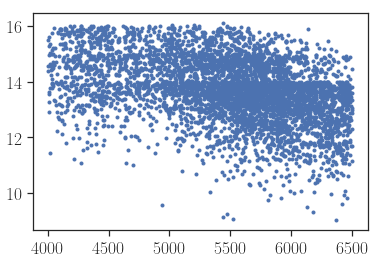

In [386]:
plt.plot(d.teff, d.kepmag, '.');

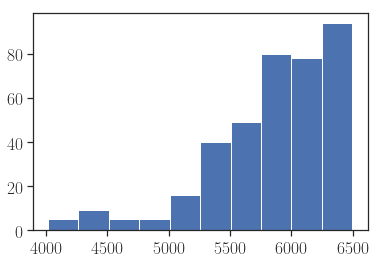

In [387]:
plt.hist(d.teff[d.kepmag<12]);

In [6]:
dt = 150
tbins = np.arange(4000, 6500, dt)

In [7]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

In [17]:
import warnings
warnings.filterwarnings('ignore')

## Fitting Rper vs Ro

In [9]:
resdir = 'plfit_bias/'

In [10]:
resume = True

In [19]:
tbins_all = np.array([4000, 6250])
tbins_all = np.array([5500, 6000])

0.3295471833206289 1.688204998769942
plfit_bias/teff5500-6000_kp12


sample: 100%|█████████████████████████████████| 2000/2000 [00:05<00:00, 342.03it/s, 15 steps of size 1.80e-01. acc. prob=0.82]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11235.58    788.85  11239.11   9871.41  12394.27    524.59      1.00
    lnp_break     -0.04      0.04     -0.04     -0.10      0.02    281.23      1.00
  lnxmodel[0]     -0.00      0.01     -0.00     -0.02      0.02   1252.60      1.00
  lnxmodel[1]      0.43      0.01      0.43      0.42      0.45   1806.08      1.00
  lnxmodel[2]      0.43      0.01      0.43      0.41      0.44   1784.64      1.00
  lnxmodel[3]      0.22      0.01      0.22      0.21      0.24   1918.28      1.00
  lnxmodel[4]      0.42      0.01      0.42      0.40      0.44   1240.98      1.00
  lnxmodel[5]      0.09      0.01      0.09      0.07      0.11   1973.38      1.00
  lnxmodel[6]      0.10      0.01      0.10      0.08      0.12   2009.01      1.00
  lnxmodel[7]      0.02      0.01      0.02      0.00      0.04   2024.16      1.00
  lnxmodel[8]     -0.57      0.01     -0.57     -0.59     -0.55   2059.87  

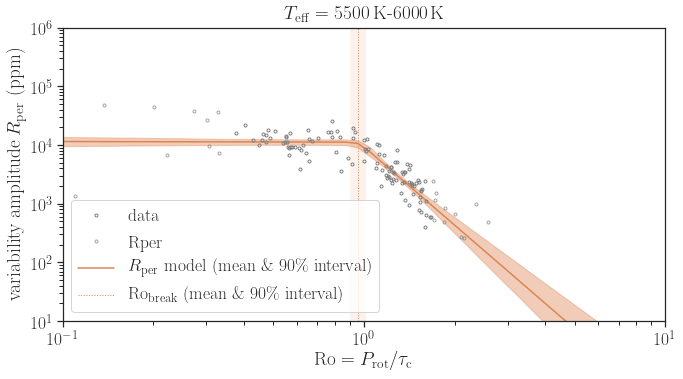

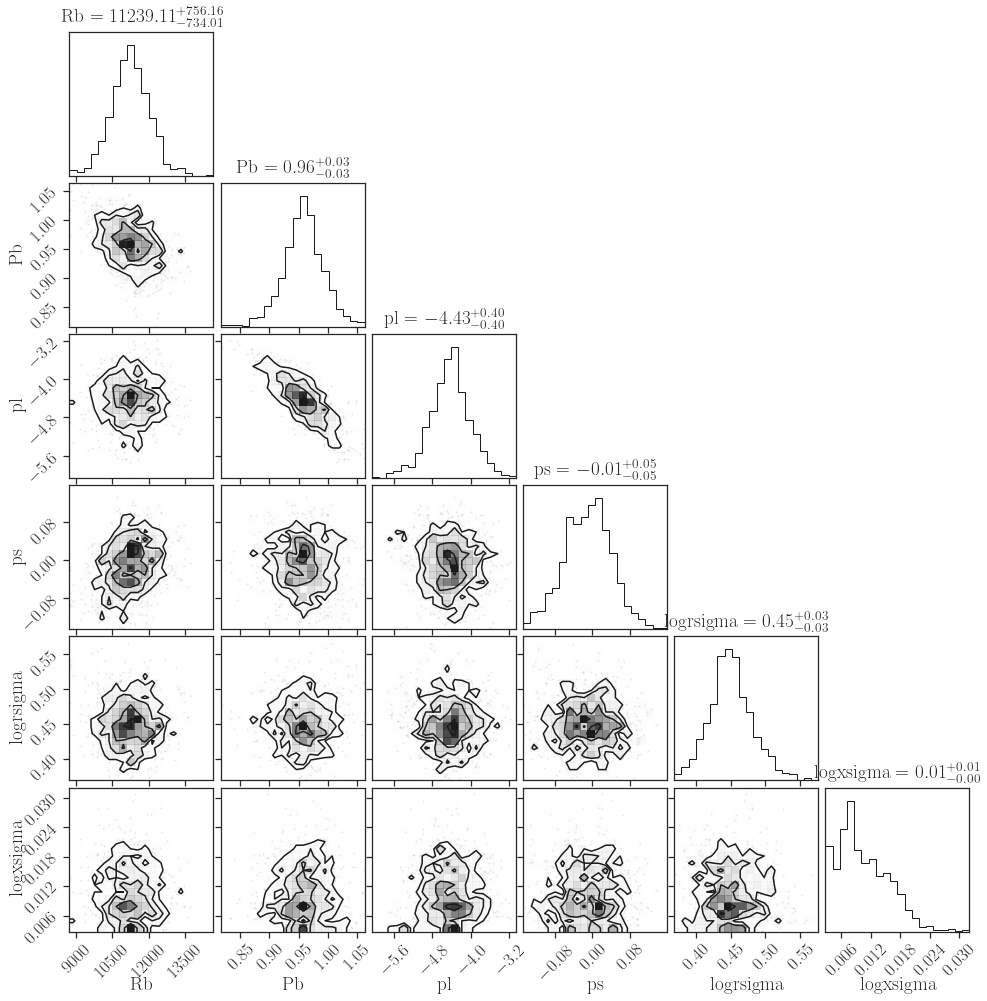

In [20]:
for i in range(len(tbins_all)-1):
    tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)   

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idx &= (d.kepmag < 12)
    outname += "_kp12"
    
    print (outname) 
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 1000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, #xb_lower=0.5, xb_upper=2., 
                 xb_lower=np.fmax(pmin, 0.5), xb_upper=np.fmin(pmax, 2.), 
                 xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if len(pobs)>300:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")
    
    keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma", "lnxsigma"]
    labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma', 'logxsigma']
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

In [368]:
def func(x, p_break, R_break, power_short, power_long):
    return np.where(x < p_break, R_break * (x/p_break)**power_short, R_break * (x/p_break)**power_long)

tau_g98 = lambda teff: 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

from scipy.interpolate import interp1d
dprec = pd.read_csv("data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

In [369]:
log10p = np.log10(d[idx].Prot)
print (np.mean(log10p), np.std(log10p))

1.0506223461780109 0.292166792114106


In [370]:
dall = pd.read_csv("sample_m14_searched.csv")
dall = dall[(dall.evState==0)&(dall.binaryFlag==0.)].reset_index(drop=True)
dall.kepmag[dall.kepmag<7] = 7

In [371]:
tlsmp, tusmp = 5500, 6000
Rbtrue, Rtrue, bsattrue, bunsattrue = 0.96, 1.1239e4, -0.01, -4.43
tlsmp, tusmp = 4000, 5500

In [372]:
idxt = (tlsmp < dall.teff) & (dall.teff < tusmp)

In [373]:
dsmp = dall[idxt].reset_index(drop=True)
#dsmp['Prot'] = 10**( np.random.randn(len(dsmp))*0.29 + 0.8)
#dsmp['Prot'] = 10**( np.random.randn(len(dsmp))*0.5 + 1.6)
dsmp['Prot'] = np.random.randn(len(dsmp)) * 15 + 25.
dsmp.Prot[dsmp['Prot']<0] = np.random.rand(np.sum(dsmp['Prot']<0)) * 40.
dsmp['Pnorm'] = dsmp.Prot / tau_g98(dsmp.teff)
dsmp['lnRper'] = np.log(func(np.array(dsmp.Pnorm), Rbtrue, Rtrue, bsattrue, bunsattrue)) + np.random.randn(len(dsmp))*0.45
dsmp['Rper'] = np.exp(dsmp.lnRper)
dsmp['Rper_th'] = 3 * kepsigma(dsmp.kepmag)

In [374]:
idxdet = dsmp.Rper > dsmp.Rper_th
print (len(dsmp), np.sum(idxdet))

23633 15257


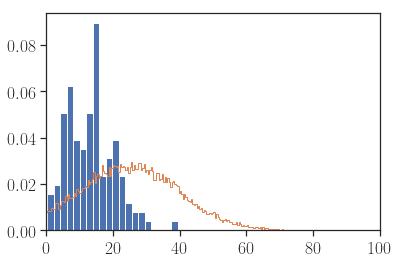

In [375]:
plt.xlim(0, 100)
plt.hist(d[idx].Prot, bins=20, density=True)
plt.hist(dsmp.Prot, density=True, bins=200, histtype='step');

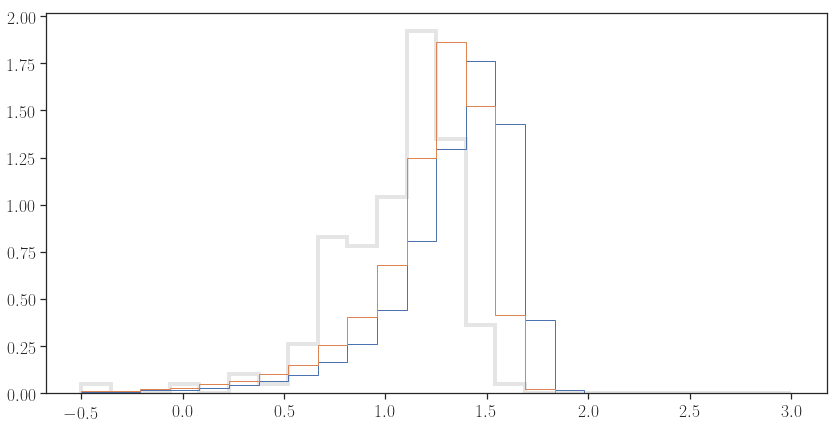

In [376]:
bins = np.linspace(-0.5, 3, 25)
plt.figure(figsize=(14,7))
plt.hist(np.log10(d[idx].Prot), density=True, bins=bins, histtype='step', color='gray', lw=4, alpha=0.2)
plt.hist(np.log10(dsmp.Prot), density=True, bins=bins, histtype='step')
plt.hist(np.log10(dsmp.Prot)[idxdet], density=True, bins=bins, histtype='step');

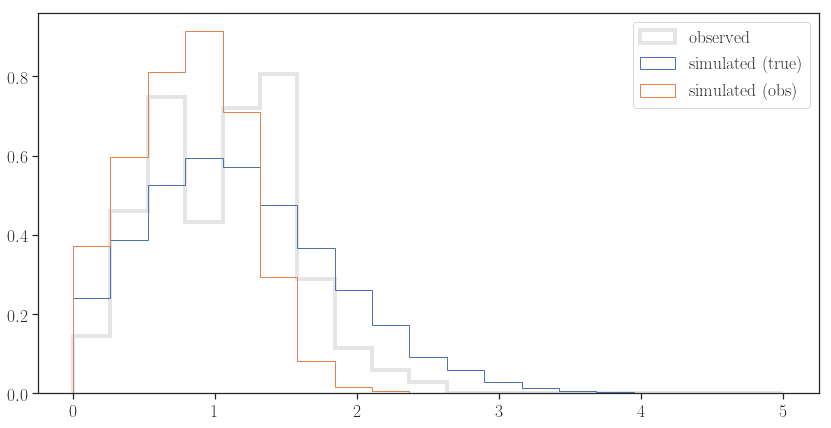

In [377]:
bins = np.linspace(0, 5, 20)
plt.figure(figsize=(14,7))
plt.hist(d[idx].Pnorm, density=True, bins=bins, histtype='step', color='gray', lw=4, alpha=0.2, label='observed')
plt.hist(dsmp.Pnorm, density=True, bins=bins, histtype='step', label='simulated (true)')
plt.hist(dsmp.Pnorm[idxdet], density=True, bins=bins, histtype='step', label='simulated (obs)')
plt.legend(loc='best')

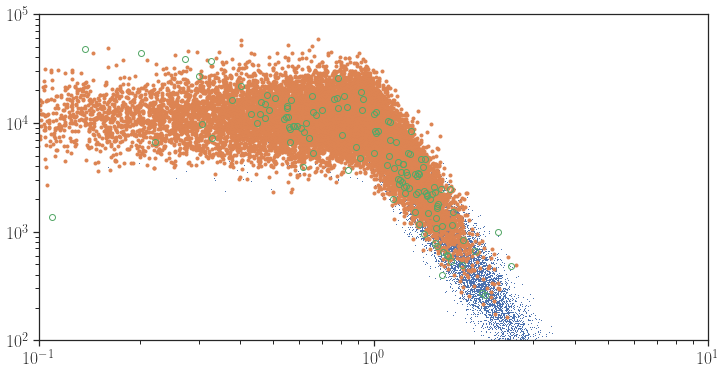

In [378]:
plt.figure(figsize=(12,6))
plt.ylim(1e2, 1e5)
plt.xlim(0.1, 10.)
plt.xscale("log")
plt.yscale("log")
plt.plot(dsmp.Pnorm, dsmp.Rper, ',')
plt.plot(dsmp.Pnorm[idxdet], dsmp.Rper[idxdet], '.')
plt.plot(d[idx].Pnorm, d[idx].Rper, 'o', mfc='none')

In [379]:
def plfit(d, tl, tu, resume=True):
    #tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"rec_teff%d-%d"%(tl, tu)   
    print (outname)

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 1000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, #xb_lower=0.5, xb_upper=2., 
                 xb_lower=np.fmax(pmin, 0.5), xb_upper=np.fmin(pmax, 2.), 
                 xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if len(pobs)>300:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")
    
    keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma", "lnxsigma"]
    labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma', 'logxsigma']
    truths = [Rtrue, Rbtrue, bunsattrue, bsattrue, None, None]
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    fig = corner.corner(hyper, labels=labels, show_titles="%.2f", truths=truths)
    plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

In [380]:
#dsmp_det = dsmp[idxdet&(dsmp.kepmag<14.)].reset_index(drop=True)

In [381]:
_dsmp_det = dsmp[idxdet].reset_index(drop=True)
dsmp_det = _dsmp_det.iloc[np.random.randint(0, len(_dsmp_det), 500)].reset_index(drop=True)

In [382]:
len(dsmp_det)

500

plfit_bias/rec_teff4000-5500
0.16982813434450786 1.4091486037163818


sample: 100%|████████████████████████████████| 2000/2000 [00:11<00:00, 173.95it/s, 127 steps of size 5.63e-02. acc. prob=0.95]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break  11575.71    423.85  11556.95  10847.76  12225.87    327.92      1.00
    lnp_break     -0.05      0.02     -0.05     -0.08     -0.02    407.94      1.00
  lnxmodel[0]     -0.21      0.01     -0.21     -0.23     -0.19   1654.40      1.00
  lnxmodel[1]     -0.92      0.01     -0.92     -0.93     -0.90   1926.85      1.00
  lnxmodel[2]     -0.16      0.01     -0.16     -0.18     -0.15   1815.00      1.00
  lnxmodel[3]     -0.78      0.01     -0.78     -0.80     -0.76   1536.77      1.00
  lnxmodel[4]     -0.09      0.01     -0.09     -0.11     -0.07   1290.50      1.00
  lnxmodel[5]     -1.41      0.01     -1.41     -1.43     -1.39   1256.91      1.00
  lnxmodel[6]     -0.56      0.01     -0.56     -0.58     -0.54   2171.76      1.00
  lnxmodel[7]      0.11      0.01      0.11      0.08      0.12   2270.10      1.00
  lnxmodel[8]     -0.03      0.01     -0.03     -0.05     -0.01   2231.87  

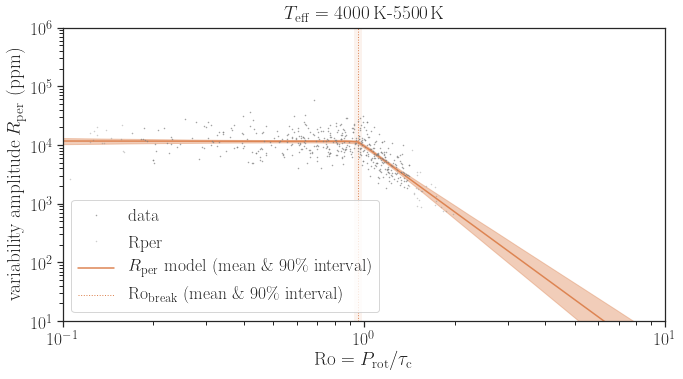

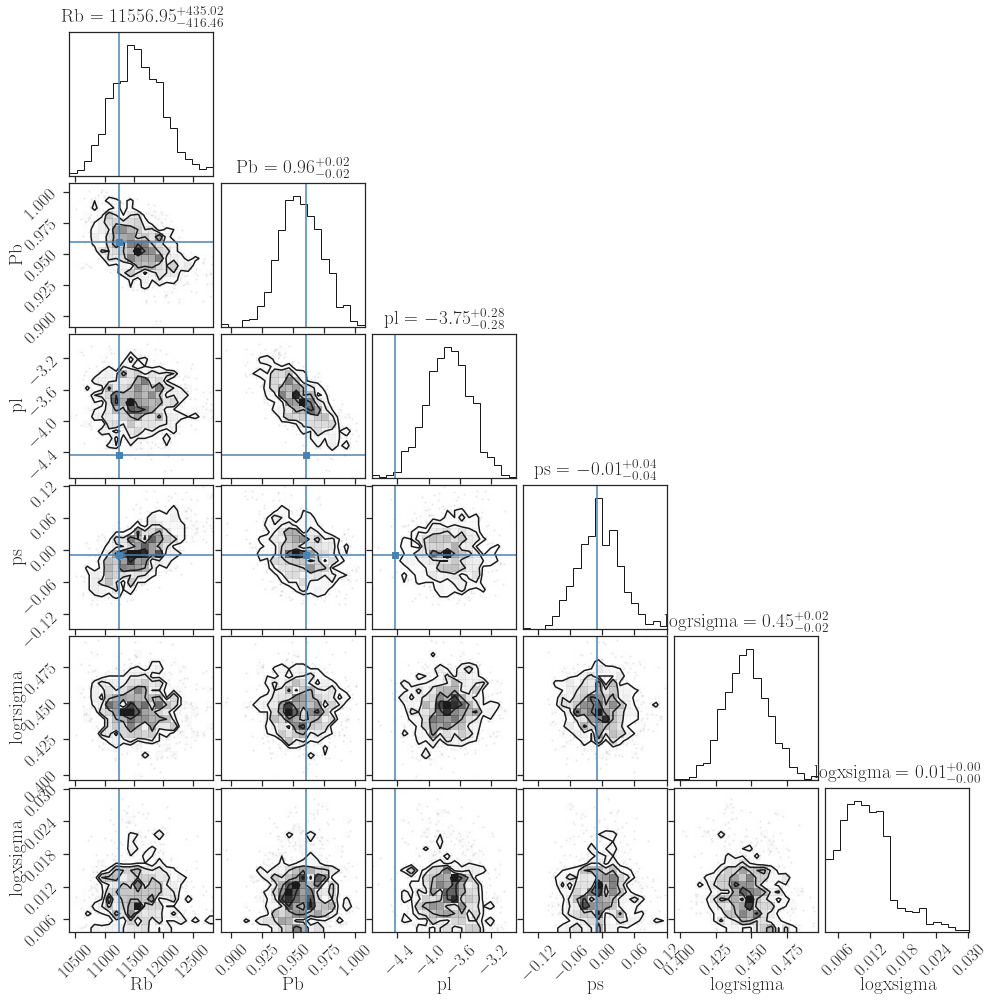

In [384]:
plfit(dsmp_det, tlsmp, tusmp, resume=True*0)